The first step is to set up the directories. Obviously, you'll need somewhere to store the ouput.

In [ ]:
from pathlib import Path
import yaml
import os

# Or similar
root_dir = Path(os.getenv("ROOT_DIR"))

# Wherever the original mosaics are saved
orig_mosaic_dir = root_dir / "archival" / "grizli-v2" / "JwstMosaics" / "v7"

# Your new favourite directory
out_base_dir = root_dir / "2024_08_16_A2744_v4" / "glass_niriss"
out_base_dir.mkdir(exist_ok=True, parents=True)

We then need to parse all of the imaging mosaics. We need to have some record of:
* Which combination of telescope, instrument, and filter corresponds to each image.
* The type of each image - science, weight, exposure, variance.

If your imaging mosaics follow the Grizli AWS / DJA format, there's an automated function to parse this information from a directory. We can also loop over each instrument/filter key to calculate the full variance mosaic (including the poisson noise).

<div class="alert alert-warning">

**Warning:**

Calculating the full variance array can require a significant amount of memory and disk space, particularly if the mosaics are very large, or are stored in compressed ".fits.gz" format. Even parsing information from the FITS header can take a long time if the files are compressed.

</div>


In [2]:
# Where to save the details
obs_dict_path = out_base_dir / "full_ancillary_data.yaml"

# Avoid parsing files again if the details already exist 
if obs_dict_path.is_file():
    
    with open(obs_dict_path, "r") as file:
        obs_dict = yaml.safe_load(file)

else:

    from glass_niriss.pipeline import parse_files_grizli_aws

    obs_dict = parse_files_grizli_aws(
        orig_mosaic_dir, out_path=out_base_dir / "full_ancillary_data.yaml"
    )

In [3]:
# Check that a variance array exists for all science images
for k, v in obs_dict.items():
    if v.get("var") is None:
        try:
            var_path = Path(v["exp"]["path"].replace("_exp", "_var"))
            assert var_path.is_file(), "var does not exist" 
        except:
            print (f"Generating var for {k}...")
            
            from glass_niriss.isophotal import calc_full_var

            try:
                var_path = calc_full_var(
                    sci_path=v["sci"]["path"], wht_path=v["wht"]["path"],
                    exp_path=v["exp"]["path"]
                )
                obs_dict[k]["var"] = {
                    "path" : str(var_path),
                    "version" : v["exp"]["version"],
                    "flag_incomplete" : v["exp"]["flag_incomplete"]
                }
            except:
                print (f"Failed to generate var for {k}")

with open(obs_dict_path, "w") as outfile:
    yaml.dump(obs_dict, outfile, default_flow_style=False, sort_keys=False)

Before we can start using these images, we want to make sure they're all aligned, at the right pixel scale, and with the same point-spread function (PSF). To do this, we need to know the PSF of each individual image. Deriving this is not (currently) part of the ``glass-niriss`` package, although PSFs for the A2744 field are included under ``data/psfs``. Some packages and useful references for deriving PSFs include [aperpy](https://github.com/astrowhit/aperpy), [photutils](https://photutils.readthedocs.io), and [PSFEx](https://psfex.readthedocs.io).

Opening ``"full_ancillary_data.yaml"`` in any suitable text editor, you'll notice there's an empty field marked ``psf`` for each filter key. Simply copy and paste the path to the relevant PSF here, and then carry on running the pipeline.

<div class="alert alert-warning">

**Warning:**

As before, the reprojection and convolution **will** require a significant amount of memory and disk space. Depending on how many filters you have, it could also take a couple hours (*eg* A2744: 38 filters, 43k x 35k mosaics -> 1.2 hours). The good news is, you only have to run this code block once.

</div>

In [4]:
from glass_niriss.isophotal import reproject_and_convolve

# Reload the full obs dict with PSF info
with open(obs_dict_path, "r") as file:
    obs_dict = yaml.safe_load(file)

# Where to save the details of the PSF-matched images
conv_dict_path = out_base_dir / "conv_ancillary_data.yaml"

# Where to save the reprojected and convolved images
conv_out_dir = out_base_dir / "PSF_matched_data"

# The reference mosaic to align the images to
ref_mosaic = (
    out_base_dir.parent / "grizli_home" / "Prep" / "glass-a2744-ir_drc_sci.fits"
)

# Avoid parsing files again if the details already exist 
if conv_dict_path.is_file():

    with open(conv_dict_path, "r") as file:
        conv_dict = yaml.safe_load(file)

else:
    conv_dict = {}
    for filt_key, old_details in obs_dict.items():
        conv_dict[filt_key] = {
            k: v for k, v in old_details.items() 
            if k not in ["exp","sci","var","wht"]
        }

        for t in ["sci","var"]:
            _conv_out_path = reproject_and_convolve(
                ref_path=ref_mosaic,
                orig_images=Path(obs_dict[filt_key][t]["path"]),
                psfs=Path(obs_dict[filt_key]["psf"]),
                psf_target=obs_dict["jwst-nircam-f444w"]["psf"],
                out_dir=conv_out_dir,
                new_names=f"repr_{filt_key}_{t}.fits",
                reproject_image_kw={"method": "adaptive", "compress": False,},
            )

            conv_dict[filt_key][t] = str(_conv_out_path[0])

    with open(conv_dict_path, "w") as outfile:
        yaml.dump(conv_dict, outfile, default_flow_style=False, sort_keys=False)

print (conv_dict)

{'hst-acs-f435w': {'filt': 'F435W', 'pupil': 'UNKNOWN', 'detector': 'WFC', 'instrument': 'ACS', 'telescope': 'HST', 'psf': '/media/sharedData/data/archival/grizli-v2/JwstMosaics/v7/UNCOVER_DR3_PSFs/f435w_psf_norm.fits', 'sci': '/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss/PSF_matched_data/conv_hst-acs-f435w_sci.fits', 'var': '/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss/PSF_matched_data/conv_hst-acs-f435w_var.fits'}, 'hst-acs-f475w': {'filt': 'F475W', 'pupil': 'UNKNOWN', 'detector': 'WFC', 'instrument': 'ACS', 'telescope': 'HST', 'psf': '/media/sharedData/data/archival/grizli-v2/JwstMosaics/v7/additional_PSFs/f475w_psf_norm.fits', 'sci': '/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss/PSF_matched_data/conv_hst-acs-f475w_sci.fits', 'var': '/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss/PSF_matched_data/conv_hst-acs-f475w_var.fits'}, 'hst-acs-f606w': {'filt': 'F606W', 'pupil': 'UNKNOWN', 'detector': 'WFC', 'instrument': 'ACS', 'telescope': 'HST', '

We now have a directory of flux and variance images, PSF-matched to our largest PSF, and aligned to a consistent pixel scale. Let's do the same to our segmentation map.

In [7]:
# The path of the original segmentation map
orig_seg = out_base_dir.parent / "grizli_home" / "Prep" / "glass-a2744-ir_seg.fits"

reproject_and_convolve(
    ref_path=ref_mosaic,
    orig_images=orig_seg,
    psfs=None,
    psf_target=None,
    out_dir=conv_out_dir,
    new_names=f"repr_glass-a2744-ir_seg.fits",
    reproject_image_kw={"method": "interp", "order": 0, "compress" : False},
)

repr_seg_path = conv_out_dir / "repr_glass-a2744-ir_seg.fits"

(5022, 5130)
{'method': 'interp', 'order': 0, 'compress': False}
/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss/PSF_matched_data/repr_glass-a2744-ir_seg.fits
Opened
Updated header
Using buffer
About to reproject


That's everything we need to start deriving spatially-resolved SEDs. Let's pull out an interesting object to look at.

[2678 2679 2679 ... 2778 2778 2778]
{'filt': 'F200W', 'pupil': 'CLEAR', 'detector': 'NRCA1', 'instrument': 'NIRCAM', 'telescope': 'JWST', 'psf': '/media/sharedData/data/archival/grizli-v2/JwstMosaics/v7/UNCOVER_DR3_PSFs/f200w_psf_norm.fits', 'sci': '/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss/PSF_matched_data/conv_jwst-nircam-f200w_sci.fits', 'var': '/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss/PSF_matched_data/conv_jwst-nircam-f200w_var.fits'}


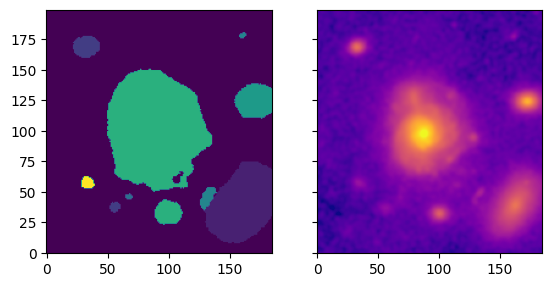

In [8]:
from astropy.io import fits
from astropy import visualization as astrovis
import matplotlib.pyplot as plt

from glass_niriss.pipeline import seg_slice

# Choose a filter to use
sn_filter = "jwst-nircam-f200w"

# A nice extended object, located behind the cluster
obj_id = 1853
obj_z = 1.3397

# Open the segmentation map
with fits.open(repr_seg_path) as repr_seg_hdul:
    repr_seg_map = repr_seg_hdul[0].data

    # Convenience function to find the location of the object
    obj_img_idxs = seg_slice(repr_seg_map, obj_id)

    print (conv_dict[sn_filter])

    with fits.open(
        conv_dict[sn_filter]["sci"]
    ) as img_hdul:

        norm = astrovis.ImageNormalize(
            img_hdul[0].data[obj_img_idxs],
            interval=astrovis.PercentileInterval(99.9),
            stretch=astrovis.LogStretch(),
        )

        fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
        axs[0].imshow(repr_seg_map[obj_img_idxs]%13)
        axs[1].imshow(img_hdul[0].data[obj_img_idxs], norm=norm, origin="lower", cmap="plasma")
        plt.show()

There's many different ways to go about this. Some authors prefer to fit every pixel, some perform an adaptive binning across the whole image to ensure a minimum signal/noise (S/N). For very large galaxies, there's a ``constrained_adaptive()`` function, where the initial binning is done in a hexagonal pattern, and any remaining pixels are run through an adaptive Voronoi binning scheme. This can ensure a minimum bin size (avoiding significant oversampling of the PSF), as well as reducing the number of bins to fit.

For this particular galaxy, given its small size, we just run through a Voronoi binning method ``constrained_adaptive(..., use_hex=False)``. We aim for a S/N of 100, and mask out pixels that aren't included in the segmentation map for this object.

2024-10-28 16:23:01,813 - stpipe - WARNING - /tmp/ipykernel_136894/1795706436.py:9: RuntimeWarning: invalid value encountered in sqrt
  noise = np.sqrt(fits.getdata(conv_dict[sn_filter]["var"]))[obj_img_idxs]



Skipping hex
Bin-accretion...
1  /  985
2  /  985
3  /  985
4  /  985
5  /  985
6  /  985
7  /  985
8  /  985
9  /  985
10  /  985
11  /  985
12  /  985
13  /  985
14  /  985
15  /  985
16  /  985
17  /  985
18  /  985
19  /  985
20  /  985
21  /  985
22  /  985
23  /  985
24  /  985
25  /  985
26  /  985
27  /  985
28  /  985
29  /  985
30  /  985
31  /  985
32  /  985
33  /  985
34  /  985
35  /  985
36  /  985
37  /  985
38  /  985
39  /  985
40  /  985
41  /  985
42  /  985
43  /  985
44  /  985
45  /  985
46  /  985
47  /  985
48  /  985
49  /  985
50  /  985
51  /  985
52  /  985
53  /  985
54  /  985
55  /  985
56  /  985
57  /  985
58  /  985
59  /  985
60  /  985
61  /  985
62  /  985
63  /  985
64  /  985
65  /  985
66  /  985
67  /  985
68  /  985
69  /  985
70  /  985
71  /  985
72  /  985
73  /  985
74  /  985
75  /  985
76  /  985
77  /  985
78  /  985
79  /  985
80  /  985
81  /  985
82  /  985
83  /  985
84  /  985
85  /  985
86  /  985
87  /  985
88  /  985
89  /  985


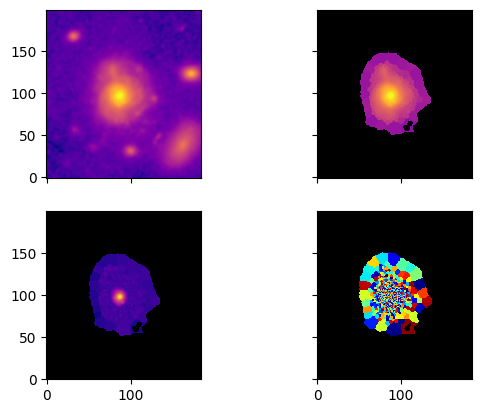

In [9]:
from glass_niriss.sed import constrained_adaptive
import numpy as np

target_sn = 50

signal = fits.getdata(conv_dict[sn_filter]["sci"])[obj_img_idxs]

# Don't forget that the noise is the square root of the variance array
noise = np.sqrt(fits.getdata(conv_dict[sn_filter]["var"]))[obj_img_idxs]

# Only use voronoi binning
hexbin = False
bin_diameter = 0

bin_labels, nbins, bin_sn, bin_inv = constrained_adaptive(
    signal=signal,
    noise=noise,
    target_sn=target_sn,
    mask = repr_seg_map[obj_img_idxs]!=obj_id,
    use_hex=False,
    plot=True
)

And finally, we can save the segmentation map, along with the binned data for all filters.

In [10]:
from glass_niriss.sed import save_binned_data

# Make a new directory for the binned data
bin_data_dir = out_base_dir / "binned_data"
bin_data_dir.mkdir(exist_ok=True, parents=True)

# Give it a meaningful name - this avoids confusion if rerunning with multiple configurations
binned_name = f"{obj_id}_{"hexbin" if hexbin else "vorbin"}_{bin_diameter}_{target_sn}"

if not (bin_data_dir / f"{binned_name}_data.fits").is_file():
    save_binned_data(
        bin_labels=bin_labels,
        out_path=bin_data_dir / f"{binned_name}_data.fits",
        filter_keys=[*conv_dict.keys()],
        signal_paths=[conv_dict[f]["sci"] for f in conv_dict.keys()],
        var_paths=[conv_dict[f]["var"] for f in conv_dict.keys()],
        crop=obj_img_idxs
    )

name 'hdr' is not defined blah hst-acs-f435w
bin_id bin_area ... jwst-niriss-f200w_sci jwst-niriss-f200w_var
------ -------- ... --------------------- ---------------------
     0    30714 ...     520.0147221507419     20.03414791994912
     1        1 ...     9.825627300809217  0.010132068438142596
     2        1 ...     8.685743585447131  0.009018366866482642
     3        1 ...     8.396465787179597  0.008737945960268835
     4        1 ...     9.401483022192242   0.00971279704836592
     5        1 ...     6.888392073504107   0.00727502553924827
     6        1 ...     7.031213502691899  0.007404970042989436
     7        1 ...      7.30087932566384  0.007683125558531753
     8        1 ...     6.145248218375292  0.006571273702001482
     9        1 ...     8.048026282182837  0.008397710160892597
   ...      ... ...                   ...                   ...
   960      112 ...     5.830651827978418   0.07793570491206368
   961       11 ...    3.0339533148616176  0.00906554249563

If you're working with multiple objects, there's also a convenient wrapper for these operations. Using a slightly different object:

2024-10-28 16:23:41,557 - stpipe - WARNING - /media/sharedData/python/py3.12_GLASS_pipeline/code/GLASS-NIRISS/src/glass_niriss/sed/binning.py:569: RuntimeWarning: invalid value encountered in sqrt
  noise = np.sqrt(fits.getdata(info_dict[sn_filter]["var"]))[obj_img_idxs]



[3388 3388 3388 ... 3451 3451 3451]
Bin-accretion...
1  /  44
2  /  44
3  /  44
4  /  44
5  /  44
6  /  44
7  /  44
8  /  44
9  /  44
10  /  44
11  /  44
12  /  44
13  /  44
14  /  44
15  /  44
16  /  44
17  /  44
18  /  44
19  /  44
20  /  44
21  /  44
22  /  44
23  /  44
24  /  44
25  /  44
26  /  44
27  /  44
28  /  44
29  /  44
30  /  44
31  /  44
32  /  44
33  /  44
34  /  44
35  /  44
36  /  44
37  /  44
38  /  44
39  /  44
40  /  44
41  /  44
42  /  44
43  /  44
44  /  44
45  /  44
46  /  44
47  /  44
48  /  44
49  /  44
50  /  44
51  /  44
52  /  44
53  /  44
54  /  44
55  /  44
56  /  44
57  /  44
58  /  44
59  /  44
60  /  44
61  /  44
62  /  44
63  /  44
64  /  44
65  /  44
66  /  44
67  /  44
68  /  44
69  /  44
70  /  44
71  /  44
72  /  44
73  /  44
74  /  44
75  /  44
76  /  44
77  /  44
78  /  44
79  /  44
80  /  44
81  /  44
82  /  44
83  /  44
84  /  44
85  /  44
86  /  44
87  /  44
88  /  44
89  /  44
90  /  44
91  /  44
92  /  44
93  /  44
94  /  44
95  /  44
96  / 

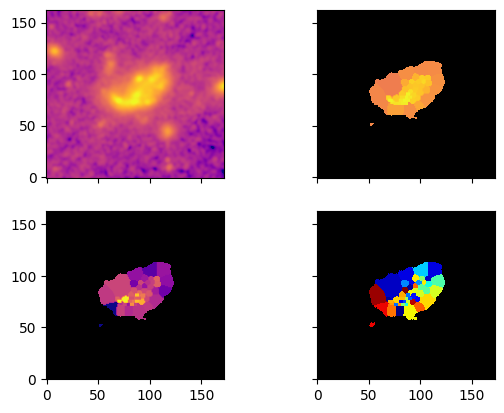

bin_id bin_area ... jwst-niriss-f200w_sci jwst-niriss-f200w_var
------ -------- ... --------------------- ---------------------
     0    25371 ...     3.610461506550849    16.061620156767745
     1       12 ...     8.565143342187055  0.015216970781028436
     2       12 ...    6.5836003638871325  0.013338265475158406
     3        9 ...     6.225766039781044  0.011309192535264124
     4       12 ...     7.757553844677023  0.014568033334674416
     5       12 ...     8.114947591194644  0.015120447960221354
     6       12 ...      5.89308915548744   0.01312999066654241
     7       12 ...     6.946235972639957  0.013680080120983784
     8        9 ...     5.216403075670188  0.010668948777179464
     9        9 ...      5.84048372382935  0.011014809141186162
   ...      ... ...                   ...                   ...
    39      144 ...      15.9474758828291   0.10248062033814287
    40       43 ...     9.448246783114929   0.03378757885599601
    41       17 ...     7.07518350112439

PosixPath('/media/sharedData/data/2024_08_16_A2744_v4/glass_niriss/binned_data/2663_hexbin_4_100_data.fits')

In [11]:
from glass_niriss.sed import bin_and_save

bin_and_save(
    obj_id = 2663,
    out_dir = bin_data_dir,
    seg_map = repr_seg_map,
    info_dict = conv_dict,
    sn_filter = "jwst-nircam-f200w",
    target_sn=100,
    bin_diameter=3,
    use_hex=True,
    overwrite=True
)